In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import model
import datetime as dt
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
data = pd.read_csv("/media/disk2/gdrozdov/GAZP_171201_190301.csv")
data.columns = data.columns.str.replace("<|>", "")
data = data.drop('TIME', 1)
data_real = data
#full_size = data_real.shape[0]
#data = data[:286]
date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
data.shape

FileNotFoundError: [Errno 2] File b'/media/disk2/gdrozdov/GAZP_171201_190301.csv' does not exist: b'/media/disk2/gdrozdov/GAZP_171201_190301.csv'

In [29]:
minmax = MinMaxScaler().fit(data.iloc[:, 1:].astype('float64'))
df_log = minmax.transform(data.iloc[:, 1:].astype('float64'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4
0,0.048613,0.051934,0.080373,0.060562,0.259183
1,0.061418,0.066710,0.085155,0.078587,0.181662
2,0.072326,0.066493,0.104508,0.075703,0.124379
3,0.068769,0.073012,0.107468,0.084114,0.146114
4,0.076832,0.063885,0.105191,0.060562,0.185942


In [30]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 30

In [31]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        loss = np.mean(loss)
        init_value = last_state
        total_loss += loss
    total_loss /= (df_log.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch: 100 avg loss: 0.0063708692446
epoch: 200 avg loss: 0.00523865064545
epoch: 300 avg loss: 0.00466315364751
epoch: 400 avg loss: 0.0041013261336
epoch: 500 avg loss: 0.00504335491987


In [32]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k + 1: k + timestamp + 1, :] = out_logits
    
out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[upper_b: , :], axis = 0),
                                     modelnn.hidden_layer: init_value})
init_value = last_state
output_predict[upper_b + 1: df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days=1))

In [33]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days=1))

In [34]:
df_log = minmax.inverse_transform(output_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

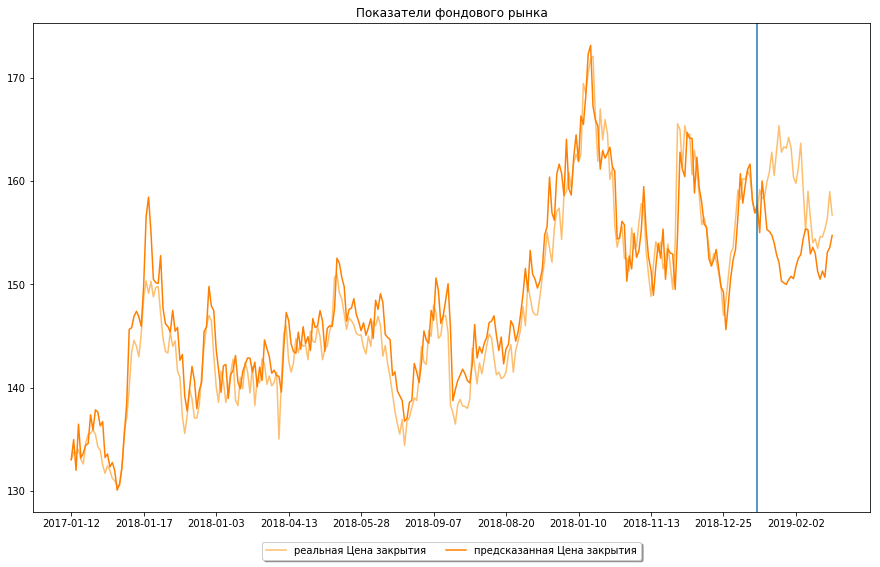

In [35]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(data_real.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(x_range_original, data_real.iloc[:, 4], label = 'реальная Цена закрытия', color = current_palette[6])
ax.plot(x_range_future, df_log[:, 3], label = 'предсказанная Цена закрытия', color = current_palette[7])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 4)
plt.axvline(x=284)#граница откуда идёт предсказание
plt.title('Показатели фондового рынка')
plt.xticks(x_range_future[::30], date_ori[::30])#через каждые 30 дней ставим метку снизу
plt.show()

In [36]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

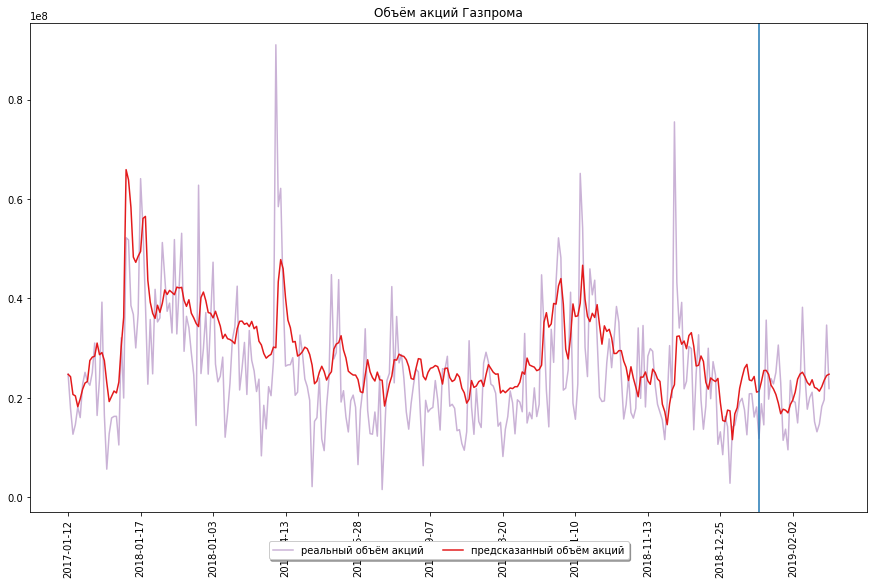

In [37]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, data_real.iloc[:, -1], label = 'реальный объём акций',color = current_palette[8])
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'предсказанный объём акций', color = current_palette[5])
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.axvline(x=286)#граница откуда идёт предсказание
plt.xticks(x_range_future[::30], date_ori[::30], rotation ='vertical')
plt.title('Объём акций Газпрома')
plt.show()

In [38]:
real_close = data_real['CLOSE'].values[full_size - future_day:]
predicted_close = df_log[:, 3][full_size - future_day:]
r2 = r2_score(real_close, predicted_close)
mse = mean_squared_error(real_close, predicted_close)
mae = mean_absolute_error(real_close, predicted_close)
print('r2_score =', round(r2, 4), 'mse =', round(mse, 4), 'mae =', round(mae, 4))

r2_score = -3.9576 mse = 59.8981 mae = 6.4134
